In [8]:
# HIDDEN
from datascience import *
%matplotlib inline

import matplotlib.pyplot as plots
from mpl_toolkits.mplot3d import Axes3D
plots.style.use('fivethirtyeight')
import pylab as pl
import math
from scipy import stats
from scipy import misc
import pandas as pd
import statsmodels.api as sm
import numpy as np

In [12]:
# HIDDEN

# Functions from earlier in the chapter

# Correlation coefficient

def corr(table, column_A, column_B):
    x = table[column_A]
    y = table[column_B]
    x_su = (x-np.mean(x))/np.std(x)
    y_su = (y-np.mean(y))/np.std(y)
    return np.mean(x_su*y_su)

# Slope and intercept of regression line

def regress(table, column_x, column_y):
    r = corr(table, column_x, column_y)
    reg_slope = r*np.std(table[column_y])/np.std(table[column_x])
    reg_int = np.mean(table[column_y]) - reg_slope*np.mean(table[column_x])
    return np.array([reg_slope, reg_int])

# Fitted value at x

def fit(table, column_x, column_y, x):
    slope_int = regress(table, column_x, column_y)
    return slope_int[0]*x + slope_int[1]

# Fitted values for all points in the scatter

def fitted_values(table, column_x, column_y):
    slope_int = regress(table, column_x, column_y)
    return slope_int[0]*table[column_x] + slope_int[1]

# Scatter plot with fitted (regression) line

def scatter_fit(table, column_x, column_y):
    t = table
    t['fit'] = fitted_values(table, column_x, column_y)
    ts = t.sort(column_x)
    plots.scatter(table[column_x], table[column_y], s=10)
    plots.plot(ts[column_x], ts['fit'], lw=1, color='green')
    plots.xlabel(column_x)
    plots.ylabel(column_y)

Now that we have explored ways to use multiple features to predict a categorical variable, it is natural to study ways of using multiple predictor variables to predict a quantitative variable. A commonly used method to do this is called *multiple regression*.

We will start with an example to review some fundamental aspects of *simple* regression, that is, regression based on one predictor variable.

### Example: Simple Regression

Suppose that our goal is to use regression to estimate height based on weight, based on a sample that looks consistent with the regression model. Suppose the observed correlation $r$ is 0.5, and that the summary statistics for the two variables are as in the table below: 

|       |**average**    |**SD**     |   
|------:|:-------------:|:---------:|
|height |69 inches      |3 inches   |
|weight |150 pounds     |20 pounds  |

To calculate the equation of the regression line, we need the slope and the intercept.

$$
\mbox{slope} ~=~ \frac{r \cdot \mbox{SD of }y}{\mbox{SD of }x} ~=~
\frac{0.5 \cdot 3 \mbox{ inches}}{20 \mbox{ pounds}} ~=~ 0.075 ~\mbox{inches per pound}
$$


$$
\mbox{intercept} ~=~ \mbox{average of }y - \mbox{slope}\cdot \mbox{average of } x
~=~ 69 \mbox{ inches} ~-~ 0.075 \mbox{ inches per pound} \cdot 150 \mbox{ pounds}
~=~ 57.75 \mbox{ inches}
$$

The equation of the regression line allows us to calculate the estimated height, in inches,
based on a given weight in pounds:

$$
\mbox{estimated height} ~=~ 0.075 \cdot \mbox{given weight} ~+~ 57.75
$$

The slope of the line is measures the increase in the estimated height per unit increase in weight. The slope is positive, and it is important to note that this does not mean that we think people get taller if they put on weight. The slope reflects the difference in the average heights of two groups of people that are 1 pound apart in weight. Specifically, consider a group of people whose weight is $w$ pounds, and the group whose weight is $w+1$ pounds. The second group is estimated to be 0.075 inches taller, on average. This is true for all values of $w$ in the sample.

In general, the slope of the regression line can be interpreted as the average increase in $y$ per unit increase in $x$. Note that if the slope is negative, then for every unit increase in $x$, the average of $y$ decreases.

### Multiple Predictors

In multiple regression, more than one predictor variable is used to estimate $y$. For example, we might want to estimate blood pressure based on both weight and age. Then the multiple regression model would involve two slopes, an intercept, and random errors as before:

blood pressure $~=~ \mbox{slope}_w * \mbox{weight} ~+~ \mbox{slope}_a * \mbox{age} ~+~ \mbox{intercept} ~+~ \mbox{random error}$

Our goal would be to find the estimated blood pressure using the best estimates of the two slopes and the intercept; as before, the "best" estimates are those that minimize the mean squared error of estimation.

The mathematics of multiple regression is complicated, and Python code for multiple regression requires knowledge of data structures that we have not covered in this course. Therefore we will just examine output to note some important parallels and differences between multiple regression and simple regression.

To start off, we will revisit the Hodgkin's disease data that we explored in our introduction to inference in simple regression. The table consists of data for a random sample of 22 patients. The variables are height in centimeters, a measure of radiation, a measure of chemotherapy, a baseline score on a test of the health of the lungs, and the score on the test taken 15 months after the treatment. It is apparent from the data that the scores tend to go down after 15 months; our goal will be to try to predict the drop in scores from baseline to 15 months, using combinations of the other variables.

In [4]:
hodgkins = Table.read_table('hodgkins.csv')
hodgkins['drop'] = hodgkins['base'] - hodgkins['month15']  # drop in scores after treatment
hodgkins

height,rad,chemo,base,month15,drop
164,679,180,160.57,87.77,72.8
168,311,180,98.24,67.62,30.62
173,388,239,129.04,133.33,-4.29
157,370,168,85.41,81.28,4.13
160,468,151,67.94,79.26,-11.32
170,341,96,150.51,80.97,69.54
163,453,134,129.88,69.24,60.64
175,529,264,87.45,56.48,30.97
185,392,240,149.84,106.99,42.85
178,479,216,92.24,73.43,18.81


### Correlation Matrix

A natural first step is to see which variables are correlated with the drop. Here is the correlation matrix. It is apparent that ``chemo`` and ``base`` are most highly correlated with ``drop``. Of course ``month15`` is correlated with ``drop`` as well, but we cannot use it for prediction because we will not have the value of that variable for a new patient.

In [5]:
# HIDDEN

df_hodgkins = pd.read_csv('hodgkins.csv')
df_hodgkins['drop'] = df_hodgkins['base'] - df_hodgkins['month15']

df_hodgkins.corr()

,height,rad,chemo,base,month15,drop
height,1.000000,-0.305206,0.576825,0.354229,0.390527,0.043394
rad,-0.305206,1.000000,-0.003739,0.096432,0.040616,0.073453
chemo,0.576825,-0.003739,1.000000,0.062187,0.445788,-0.346310
base,0.354229,0.096432,0.062187,1.000000,0.561371,0.630183
month15,0.390527,0.040616,0.445788,0.561371,1.000000,-0.288794
drop,0.043394,0.073453,-0.346310,0.630183,-0.288794,1.000000


To start off, let us perform the simple regression of ``drop`` on just ``base``, the baseline score. Here is the scatter diagram and regression line, produced using the function ``scatter_fit`` that we defined earlier in the course. You can see that the regression model fits reasonably well.

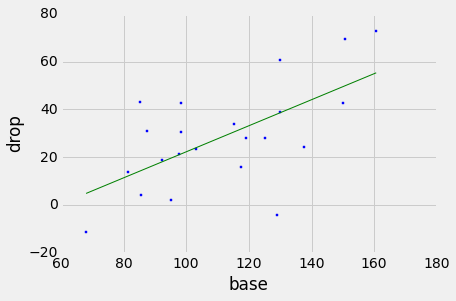

In [12]:
scatter_fit(hodgkins, 'base', 'drop')

The regression output that we have seen thus far has been rather straightforward, based on code that we wrote as a collection of straightfoward functions. The output display below is produced by Python and is very similar to regression output produced by many statistical systems: they contain a large number of summary statistics, many of which are not needed for getting a solid initial grasp of the results.

We will ignore the third display table altogether, and focus on the first two.

In the top table, much of the left hand side is self-explanatory. "OLS" stands for "ordinary least squares," which is a name for our regression model. You can ignore "Df Residuals" for now, and also "Covariance Type," but note the "Df Model" simply gives the number of predictor variables. It is 1 because we have just one predictor, ``base``.

We will ignore all of the right hand side of the table other than "R-squared". According to the correlation matrix above, the correlation between ``drop`` and ``base`` is just over 0.63; square than number to get 0.397. We will come back to this quantity, to see how its definition can be extended in the case of multiple regression. 

In [6]:
# HIDDEN

x = df_hodgkins[['base']]
y = df_hodgkins['drop']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   drop   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     13.17
Date:                Sat, 05 Dec 2015   Prob (F-statistic):            0.00167
Time:                        14:47:05   Log-Likelihood:                -92.947
No. Observations:                  22   AIC:                             189.9
Df Residuals:                      20   BIC:                             192.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -32.1721     17.151     -1.876      0.075       -67.949     3.604
base           0.5447      0.150      3.630      0.002         0.232     0.858
==============================================================================
Omnibus:                        1.133   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.568   Jarque-Bera (JB):                0.484
Skew:                          -0.362   Prob(JB):                        0.785
Kurtosis:                       3.069   Cond. No.                         530.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The "coef" column of the second table provides the intercept and slope of the regression line:

$$
\mbox{estimate of drop} ~=~ 0.5447 \cdot \mbox{base} ~-~ 32.1721
$$

The results for the slope and intercept are the same as what we would get based on our familiar methods for calculating those quantities:

In [36]:
slope = 0.630183*np.std(hodgkins['drop'])/np.std(hodgkins['base'])
slope

0.54472722699276954

In [37]:
intercept = np.mean(hodgkins['drop']) - slope*np.mean(hodgkins['base'])
intercept

-32.172182995494026

Notice the interval (0.232, 0.858), which is labeled to be a 95% confidence interval for the slope. Our method for computing such an interval would be to bootstrap the scatter diagram many times, compute the slope of the regression line, each time, draw the empirical histogram of the slopes, and pick off the central 95% interval. The interval in the display above has been computed using mathematical formulae for the endpoints; our bootstrap intervals are likely to be very close.

Note also that the interval does not contain 0. We can therefore conclude, at least with 95% confidence, that the slope of the true line is not 0; in other words, there is a genuine linear trend in the relation between ``drop`` and ``base``. 

The other columns of the second table address the question of whether the true slope is 0. We will return to those later, but in practical terms they are essentially redundant because of the information in the confidence intervals.

**Definition of $R^2$, consistent with our old $r^2$**

When we studied simple regression, we had noted that 

$$
r ~=~ \frac{\mbox{SD of fitted values of }y}{\mbox{SD of observed values of } y}
$$

Let us use our old functions to compute the fitted values and confirm that this is true for our example:

In [38]:
fitted = fitted_values(hodgkins, 'base', 'drop')
np.std(fitted)/np.std(hodgkins['drop'])

0.63018263544448383

Because variance is the square of the standard deviation, we can say that

$$
0.397 ~=~r^2 ~=~ \frac{\mbox{variance of fitted values of }y}{\mbox{variance of observed values of }y}
$$

Notice that this way of thinking about $r^2$ involves only the estimated values and the observed values, *not the number of predictor variables*. Therefore, it motivates the definition of *multiple $R^2$*:

$$
R^2 ~=~ \frac{\mbox{variance of fitted values of }y}{\mbox{variance of observed values of }y}
$$

It is a fact of mathematics that this quantity is always between 0 and 1. With multiple predictor variables, there is no clear interpretation of a sign attached to the square root of $R^2$. Some of the predictors might be positively associated with $y$, others negatively. An overall measure of the fit is provided by $R^2$. In the examples below, we will address the question of whether or not it is a good idea to try to get the biggest possible value of $R^2$.

### Multiple regression of the drop in scores, using baseline and chemo as predictors

We are now well placed to peform and interpret the multiple regression of ``drop`` based on ``chemo`` and ``base`` as the predictors. Here is a graph that demonstrates the results. The scatter plot is now three dimensional, with the response variable ``drop`` plotted on the vertical axis. The fitted values all lie on the green plane. Some of the points are above the plane, some below. The mean squared distance between the points and this plane is the smallest among all planes.

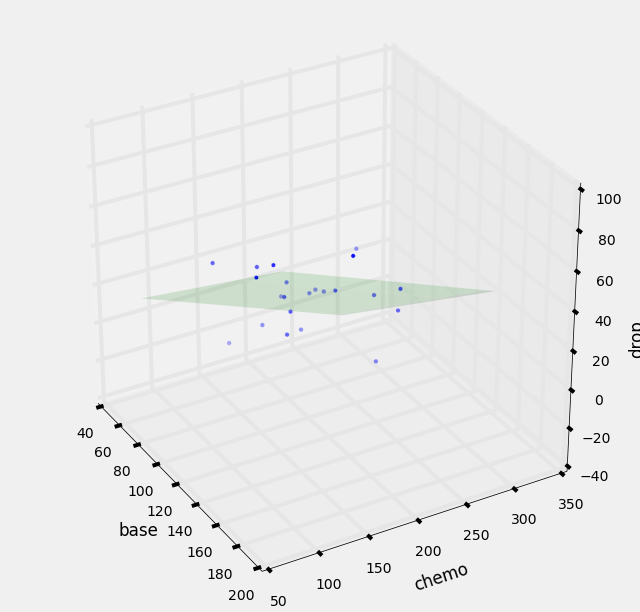

In [9]:
# HIDDEN

x = df_hodgkins[['base', 'chemo']]
y = df_hodgkins['drop']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()

fig = plots.figure(figsize=(10,10))
ax = plots.axes(projection='3d')
ax.scatter(xs=hodgkins['base'], ys=hodgkins['chemo'], zs=hodgkins['drop'], zdir='z')
x = np.arange(50,200,10)
y = np.arange(80,300,10)
x,y = np.meshgrid(x,y)
z = 0.5655*x - 0.1898*y + 0.9992
ax.plot_surface(x,y,z,alpha=0.15,color='g')
ax.view_init(elev=32,azim=330)
ax.set_xlabel('base')
ax.set_ylabel('chemo')
ax.set_zlabel('drop', rotation=90)

The numerical results are displayed below. Notice the "Df Model", the number of predictors, has risen from 1 to 2. The regression equation, to be used for estimation and prediction, is

$$
\mbox{estimated drop} ~=~ 0.5655 \cdot \mbox{base} ~-~ 0.1898 \cdot \mbox{chemo} ~+~ 0.992
$$

There is now a 95% confidence interval for each of the two true slopes; neither of the intervals contains 0. 

To understand what the slope means when there are multiple predictors, keep in mind that the slope corresponding to a predictor is the estimated increase in $y$ per unit change in that predictor, *provided all the other predictors are held constant*. To see whether it is actually reasonable to consider increasing ``base`` by while holding ``chemo`` constant, it is necessary to examine the relation between ``base`` and ``chemo``: if they are highly correlated, you can't change one without also changing the other. In fact, the correlation between ``base`` and ``chemo`` is only about 0.06, which is very small. So for example the slope of -0.1898 for ``chemo`` can be interpreted as the average increase (actually a decrease) in ``drop`` per unit change in ``chemo`` provided ``base`` is held constant.

As defined earlier in this section, the value of $R^2$ is the ratio of the variance of the fitted values and the variance of the observed values of ``drop``. Now $R^2$ is almost 0.55, noticeably higher than its value of roughly 0.4 in the simple regression of ``drop`` on ``base`` alone. 

In [10]:
# HIDDEN

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   drop   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     11.44
Date:                Sat, 05 Dec 2015   Prob (F-statistic):           0.000548
Time:                        14:51:00   Log-Likelihood:                -89.820
No. Observations:                  22   AIC:                             185.6
Df Residuals:                      19   BIC:                             188.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.9992     20.227      0.049      0.961       -41.336    43.335
base           0.5655      0.134      4.226      0.000         0.285     0.846
chemo         -0.1898      0.076     -2.500      0.022        -0.349    -0.031
==============================================================================
Omnibus:                        0.853   Durbin-Watson:                   1.781
Prob(Omnibus):                  0.653   Jarque-Bera (JB):                0.368
Skew:                          -0.317   Prob(JB):                        0.832
Kurtosis:                       2.987   Cond. No.                     1.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

It is a fact of mathematics that $R^2$ will increase if you include more predictor variables (unless they are perfectly uncorrelated with $y$). It is tempting, therefore, to include as many predictors as possible. However, this is not always useful, as can be seen if we regress ``drop`` on ``base``, ``chemo``, and ``height``. The value of $R^2$ does increase, but by a very small amount; the 95% confidence interval for the slope of ``height`` contains 0; in any case, since ``height`` is correlated with both ``base`` and ``chemo``, it is hard to intrepret any of the individual slopes. Therefore it is not an overall gain to include ``height`` as a predictor.

The quantity "Adj. R-squared" is a version of $R^2$ that has carries a penalty for using too many predictor variables. We will not go into the mathematics of this statistic. Just note that its value is 0.499 for the regression on the two predictors ``base`` and ``chemo``, but it drops to 0.473 when ``height`` is included as well. A drop in the adjusted $R^2$ is often used as an indication that some of the predictors should not be used.

In [11]:
# HIDDEN 

x = df_hodgkins[['base', 'chemo', 'height']]
y = df_hodgkins['drop']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   drop   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     7.288
Date:                Sat, 05 Dec 2015   Prob (F-statistic):            0.00212
Time:                        14:51:10   Log-Likelihood:                -89.768
No. Observations:                  22   AIC:                             187.5
Df Residuals:                      18   BIC:                             191.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -22.8397     84.026     -0.272      0.789      -199.372   153.693
base           0.5485      0.149      3.681      0.002         0.235     0.862
chemo         -0.2066      0.097     -2.135      0.047        -0.410    -0.003
height         0.1677      0.573      0.293      0.773        -1.035     1.371
==============================================================================
Omnibus:                        0.604   Durbin-Watson:                   1.766
Prob(Omnibus):                  0.739   Jarque-Bera (JB):                0.227
Skew:                          -0.248   Prob(JB):                        0.893
Kurtosis:                       2.954   Cond. No.                     6.97e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""